In [102]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_state_city

from qiskit.opflow import I, X, Y, Z, CZ
from qiskit.opflow import (StateFn, Zero, One, Plus, Minus, H,
                           DictStateFn, VectorStateFn, CircuitStateFn, OperatorStateFn)
from qiskit.opflow import MatrixOp, CircuitOp

from scipy.stats import unitary_group
from scipy.special import expit

import matplotlib.pyplot as plt

import random

from sklearn.model_selection import train_test_split

import pandas as pd

from qiskit.algorithms.optimizers import SPSA

# Generating artificial data 

In [2]:
def phi(S, x):
    '''
    Feature embedding for nqubits = 2
    '''
    if len(S)==2:
        return (np.pi - x[0])*(np.pi - x[1])
    else:
        return x[S[0]- 1]
    

def U(x):
    '''
    Unitary of PauliSum operator
    '''
    H = (phi((1,),x)  *  Z^I) + \
        (phi((2,),x)  *  I^Z) + \
        (phi((1,2),x) *  Z^Z)

    return (-1*H).exp_i()

def fancyU(x):
    '''
    Feature map
    '''
    u = U(x)
    return u @ (H^H) @ u @ (H^H) 

In [3]:
V = MatrixOp(unitary_group.rvs(4)) #random unitary group
F = Z^Z #parity function

In [4]:
domain = np.linspace(0,2*np.pi,100)

In [5]:
def f(x, delta=0.3):
    Phi = fancyU(x) @ Zero

    y = ((~Phi @ ~V @ F @ V @ Phi).eval()).real

    # labelling criteria
    if(y > delta):
        return 1
    elif(y < -1*delta):
        return -1
    else:
        return 0

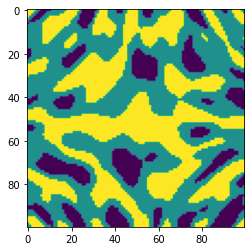

In [3]:
grid =np.array([[f([i,j]) for i in domain] for j in domain])

plt.imshow(grid)

In [ ]:
pd.DataFrame(grid).to_csv(r"./data/data1.csv")

## Sampling train and test dataset


In [39]:
grid = pd.read_csv(r"./data/data1.csv")

data = np.array(grid.iloc[:,1:])

data

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]], dtype=int64)

In [40]:
domain2 = np.array([[(i,j) for i in domain] for j in domain])

data2 = np.dstack((data, domain2))

data2df = pd.DataFrame(data2.reshape(100*100, 3))

data2Plus = np.array(data2df[data2df[0] > 1e-5])
data2Minus = np.array(data2df[data2df[0] < -1e-5])

data2Plus_sample = random.sample(list(data2Plus), 40)
data2Minus_sample = random.sample(list(data2Minus), 40) 

data = pd.DataFrame(data2Plus_sample + data2Minus_sample)

cols = list(data.columns)
cols = cols[1:] + [cols[0]] 
data = data[cols]

data.columns = ["x", "y", "c"]

data

,x,y,c
0,4.252257,3.490659,1.0
1,4.379190,0.063467,1.0
2,2.030929,0.698132,1.0
3,5.204254,2.157862,1.0
4,2.538661,0.444266,1.0
...,...,...,...
75,6.092786,5.902386,-1.0
76,0.000000,1.269330,-1.0
77,1.205864,4.569589,-1.0
78,3.871458,5.965853,-1.0


In [15]:
data.to_csv("./data/data_partitioned.csv", index=False)

In [83]:
data = pd.read_csv(r"./data/data_partitioned.csv")

In [84]:
X, y = data.iloc[:,:2], data.iloc[:,2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)

## Performance of classical classifiers

In [85]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [86]:
# Linear SVC
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.575

In [87]:
# Nonlinear SVC
clf = svm.NuSVC(gamma="auto")
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.625

In [88]:
# Logistic Regression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.575

In [89]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=10, max_iter=3000000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.625

In [90]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=200, random_state=0)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7

# Kernel Classifier

In [91]:
def allBits(n):
    '''
    Enumerates all binary strings of length n 
    '''
    if n: yield from ( bits+bit for bits in allBits(n-1) for bit in ("0","1") )
    else: yield ""

def fBool(x):
    '''
    Boolean function f
    '''
    return (-1)**x.count("1")

def fBool_op(func=fBool):
    '''
    Boolean function f as an operator
    '''
    return MatrixOp(np.diag([func(x) for x in allBits(2)]))

def W(ts):
    '''
    ts has shape (l: depth, 2: qubits, 2: parameters per qubit)
    '''
    W = I^I
    for i,t in enumerate(ts):
        if(i==0):
            W = W_sub(t, first=True) @ W
        else:
            W = W_sub(t) @ W
            
    return W

def W_sub(t, first=False):
    '''
    One layer of the feature map, including the base case for depth = 0
    '''
    U_rot_1 = (((-1/2)*t[0][0]*Z).exp_i()) @ (((-1/2)*t[0][1]*Y).exp_i())
    U_rot_2 = (((-1/2)*t[1][0]*Z).exp_i()) @ (((-1/2)*t[1][1]*Y).exp_i())
    
    if(first):
        return (U_rot_1^U_rot_2) 
    else:
        return (U_rot_1^U_rot_2) @ CZ

def M(y, func=fBool):
    '''
    Projection 
    '''
    return 1/2*((I^I) + y*F)#*fBool_op(func))

def p(ts, x, y):
    '''
    Probability of the state W(ts)|Phi(x)> actually being y 
    i.e. expectation value of projection observable M(y)
    '''
    Phi = fancyU(x) @ Zero
    return (~Phi @ ~W(ts) @ M(y) @ W(ts) @ Phi).eval().real

def kernelPredict(ts, x, y, b=0):
    '''
    Returns (ypred, prob(ytruth), ytruth) 
    '''
    pplus = p(ts, x, 1)

    if(pplus>(1-b)/2):
        if(int(y)==1):
            return (1, pplus, y)
        else:
            return (1, 1-pplus, y)
    else:
        if(int(y)==-1):
            return (-1, 1-pplus, y)
        else:
            return (-1, pplus, y)

def error(ts, x,y, b=0):
    '''
    Misclassification error 
    '''
    ypred, pytruth, ytruth = kernelPredict(ts, x,y)
    return expit(np.sqrt(200)*(0.5 - (pytruth - ytruth*b/2))/(np.sqrt(2*(1-pytruth)*pytruth)))
    

def R(ts,b=0, X_train=X_train, y_train=y_train):
    '''
    Loss function over entire training dataset 
    '''
    ts = ts.reshape(l,2,2)
    es = []
    
    for x,y in zip(X_train.iterrows(), y_train):
        es.append(error(ts, np.array(x[1]), y))
    
    return np.mean(es)

In [92]:
import sys

In [129]:
k = 0
vals = []

In [130]:
def progress(evals, pars, val, size, accepted):
    '''
    Function called at the end of each SPSA iteration
    '''
    global k
    global vals
    sys.stdout.write('\r')
    sys.stdout.write("Iter: {} Loss: {:.10}".format(k,val))
    vals.append(val)
    k+=1
    sys.stdout.flush()

## Depth = 1

In [127]:
l = 1 # depth
ts = 2*np.pi*np.random.random((l, 2,2)) #initial point

In [131]:
spsa = SPSA(maxiter=250, callback=progress)
result = spsa.optimize(l*2*2, R, initial_point=ts.reshape(l*2*2,))

Iter: 249 Loss: 0.2619026719

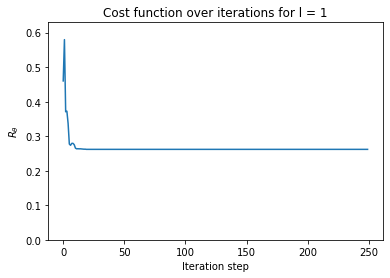

In [132]:
plt.ylim(0, max(vals)+0.05)
plt.title("Cost function over iterations for l = 1")
plt.ylabel("$R_{θ}$")
plt.xlabel("Iteration step")
plt.plot(vals)
plt.savefig("lossl1.jpg")

In [142]:
pd.DataFrame(vals).to_csv(".\data\costl1.csv")

In [133]:
# l = 1
acc = []
for i,j in zip(X_test.iterrows(), y_test):
    acc.append(kernelPredict(result[0].reshape(l,2,2), np.array(i[1]), 1, b=0)[0] == j)
np.mean(acc)

0.825

In [134]:
result

(array([2.36697719, 4.35120058, 0.50806281, 3.98973061]),
 0.2619026710478341,
 750)

In [135]:
pd.DataFrame(result[0]).to_csv(".\data\opt_thetasl1.csv")

In [136]:
datapred = np.array([[kernelPredict(result[0].reshape(l,2,2), domain2[j][i],1)[0] for i in range(len(domain2))] for j in range(len(domain2))])

In [137]:
datapred2 = datapred.copy()
datapred2_reshaped = datapred2.reshape(100*100,)
for k,(i,j) in enumerate(zip(datapred2_reshaped, data2.reshape(100*100,3,))):
    if(j[0]==0):
        datapred2_reshaped[k] = 0

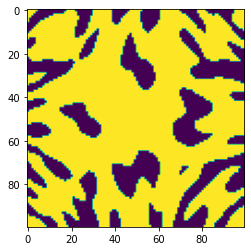

In [138]:
plt.imshow(datapred)

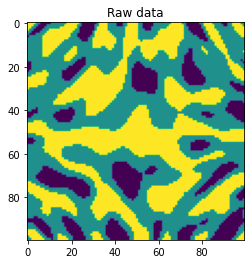

In [139]:
plt.title("Raw data")
plt.imshow(np.array(grid.iloc[:,1:]))

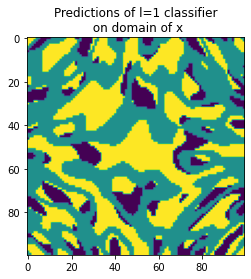

In [140]:
plt.title("Predictions of l=1 classifier\n on domain of x")
plt.imshow(datapred2);

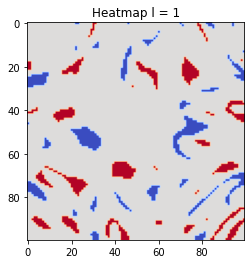

In [141]:
plt.title("Heatmap l = 1")
plt.imshow(datapred2 - np.array(grid.iloc[:,1:]), cmap="coolwarm");
plt.savefig("heatmapl1.jpg")

## Depth = 5

In [103]:
l = 5
ts = 2*np.pi*np.random.random((l, 2,2)) #initial point

In [104]:
spsa = SPSA(maxiter=250, callback=progress)
result = spsa.optimize(l*2*2, R, initial_point=ts.reshape(l*2*2,))

Iter: 249 Loss: 0.005884511998

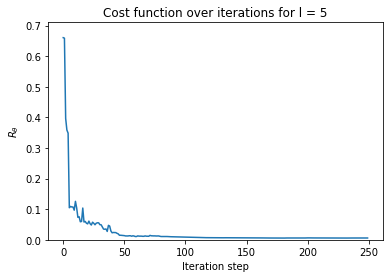

In [105]:
plt.ylim(0, max(vals)+0.05)
plt.title("Cost function over iterations for l = 5")
plt.ylabel("$R_{θ}$")
plt.xlabel("Iteration step")
plt.plot(vals)
plt.savefig("lossl5.jpg")

In [126]:
pd.DataFrame(vals).to_csv(".\data\costl5.csv")

In [106]:
acc = []
for i,j in zip(X_test.iterrows(), y_test):
    acc.append(kernelPredict(result[0].reshape(l,2,2), np.array(i[1]), 1, b=0)[0] == j)
np.mean(acc)

1.0

In [107]:
result

(array([ 0.62434945,  1.29969083,  3.96711115,  2.31966374,  2.24226307,
         3.6335569 ,  4.79435065,  0.48878012, -0.98942399, -1.76626858,
         4.14650158,  4.53346548,  2.16458935,  2.61283279,  2.93091439,
         7.7467994 ,  2.36142078,  3.93851547,  4.65163752,  5.31605094]),
 0.005884511997790066,
 750)

In [108]:
pd.DataFrame(result[0]).to_csv(".\data\opt_thetasl5.csv")

In [109]:
ts = np.array(pd.read_csv(".\data\opt_thetasl5.csv").iloc[:,1])

In [110]:
datapred = np.array([[kernelPredict(ts.reshape(l,2,2), domain2[j][i],1)[0] for i in range(len(domain2))] for j in range(len(domain2))])

In [111]:
datapred2 = datapred.copy()

datapred2_reshaped = datapred2.reshape(100*100,)
for k,(i,j) in enumerate(zip(datapred2_reshaped, data2.reshape(100*100,3,))):
    if(j[0]==0):
        datapred2_reshaped[k] = 0

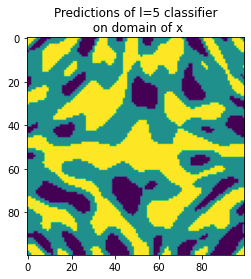

In [112]:
plt.title("Predictions of l=5 classifier\n on domain of x")
plt.imshow(datapred2);

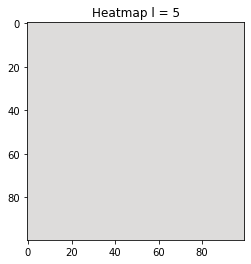

In [113]:
plt.title("Heatmap l = 5")
plt.imshow(datapred2 - np.array(grid.iloc[:,1:]), cmap="coolwarm", vmin=-1, vmax=1);
plt.savefig("heatmapl5.png")

# Quantum Kernel Estimation

In [116]:
def innerProduct(x1,x2):
    '''
    Transition probability of |phi(x1)> to |phi(x2)>
    '''
    Phi1 = fancyU(x1) @ Zero
    Phi2 = fancyU(x2) @ Zero

    return np.abs((~Phi2 @ Phi1).eval())**2

In [118]:
X_train_sorted = X_train.reindex(pd.Series.sort_values(y_train).index)

In [119]:
K = np.array([[innerProduct(x1,x2) for x1 in X_train_sorted.to_numpy()] for x2 in X_train_sorted.to_numpy()])

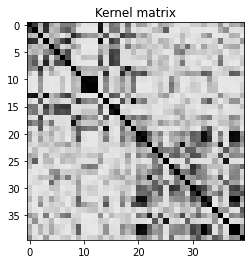

In [122]:
plt.title("Kernel matrix") 
plt.imshow(K, cmap="Greys",vmin=-0.2,vmax=1, )
plt.savefig("kernelmatrix.jpg")